Simple baseline utlizing Resnet18 pretrained on ImageNet. The below results are from finetuning only the last layer. This can be set to fine tune all parameters as well. 

Below code assumes the following directory structure: <br>
<b>dseg_660</b> <br>
    |--imgs <br>
    |--labels <br>
    |--Cocos_Baseline.ipynb <br>
    
pip/conda install the below packages if it isn't installed already. Namely, you will need pytorch, numpy, pandas, matplotlib, tqdm, sklearn and ml_metrics. 

In [1]:
from __future__ import print_function
from __future__ import division

# Pytorch DL framework imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset

# Standard python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import os
import copy
from PIL import *
from pathlib import Path

# Progress bar
from tqdm import tqdm_notebook as tqdm

# Function for shuffling the dataset
from sklearn.utils import shuffle

# Imports for calculating metrics
import ml_metrics as metrics

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [2]:
# Check if gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); device

device(type='cuda', index=0)

In [3]:
DIR = Path("./").absolute()
DATA_DIR = DIR / 'labels'
IMG_DIR_TRAIN = DIR / 'imgs/train/'
IMG_DIR_TEST = DIR / 'imgs/test/'
data_csv= DATA_DIR / 'labels_train.csv'

## Data

In [4]:
cats = pd.read_csv(DATA_DIR / "categories.csv", header=None)
cats = list(cats[0]); cats

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [5]:
data = pd.read_csv(data_csv)

In [6]:
data.head()

,000000000001.jpg,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,...,0.0.67,0.0.68,0.0.69,0.0.70,0.0.71,0.0.72,0.0.73,0.0.74,0.0.75,0.0.76
0,000000000002.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000000000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000000000005.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000000000006.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000000000007.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Custom Dataset Object
We need to define a custom dataset object to define how raw img files will be loaded into the system for training/testing

In [7]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transformations, train):
        """
        Args:
            csv_path (string): path to csv file
            transformations: pytorch transforms for transforms and tensor conversion
            train: flag to determine if train or val set
        """
        # Transforms
        self.transforms = transformations
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        
        # IMPORTANT: dataset needs to be shuffled because by default,
        # the loaded dataset has an ordering which may cause examples of 
        # certain classes from being missed in the training set if following 
        # the below method to create a train/val split
        self.data_info = shuffle(self.data_info)
        
        # First 90k images becomes the training set and the rest becomes
        # validation set
        if train:
            self.image_arr = (self.data_info.iloc[:90000, 0])
        else:
            self.image_arr = (self.data_info.iloc[90000:, 0])
  
        self.image_arr = np.asarray(self.image_arr)
        
        # Second column is the labels
        if train:
            self.label_arr = np.asarray(self.data_info.iloc[:90000, 1:])
        else:
            self.label_arr = np.asarray(self.data_info.iloc[90000:, 1:])

        # Calculate len
        self.data_len = len(self.label_arr)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        
        # Open image
        img_as_img = Image.open(IMG_DIR_TRAIN / single_image_name).convert('RGB')

        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [8]:
model_name = "resnet"

# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model
feature_extract = True

# Number of classes
num_classes = 80

# Img model input size
im_size = 224

In [9]:
# Transformations on the data
transformations = transforms.Compose([transforms.Resize((im_size, im_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# Define a dictionary of dataset
# one for train and one for validation4
image_datasets = {'train': CustomDatasetFromCSV(data_csv, transformations, True), 
                 'val': CustomDatasetFromCSV(data_csv, transformations, False)}

# Define data loader [set num_workers to 0 or 1 if on windows]
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=6) for x in ['train', 'val']}

## Model

In [10]:
# Function for calculating accuracy of the model
def calc_accuracy(preds, labels):
    return (np.sum(np.around(preds.cpu().detach().numpy()) == labels.cpu().detach().numpy()))

# Function for calculating MEAN Average Precision(MAP) score
def calc_map(preds, labels):
    preds = np.around(preds.cpu().detach().numpy())
    labels = labels.cpu().detach().numpy()             
    pred = []
    for i in preds:
        cats = np.nonzero(list(i))[0]
        pred.append(list(cats))
    label = []
    for i in labels:
        cats = np.nonzero(list(i))[0]
        label.append(list(cats))
    return metrics.mapk(label, pred)

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_mapk = 0.0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.float()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    # For multi-label
                    outputs = torch.sigmoid(outputs)
                    loss = criterion(outputs, labels)

                    preds = outputs

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += calc_accuracy(preds, labels.data)
                running_mapk += calc_map(preds, labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            epoch_mapk = running_mapk / len(dataloaders[phase])
            print('{} Loss: {:.4f} Acc: {:.4f} MAP: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_mapk))

            # deep copy the model [TODO: change to save based on mapk]
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [18]:
# Set which parts of the model should be trained
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
   
    model_ft = None
    input_size = 0

    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = im_size
    
    return model_ft, input_size
    
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [20]:
# Send the model to GPU
model_ft = model_ft.to(device)

In [21]:
# Gather the parameters to be optimized/updated in this run. If we are
# finetuning we will be updating all parameters. However, if we are
# doing feature extract method, we will only update the parameters
# that we have just initialized, i.e. the parameters with requires_grad
# is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Params to learn:
	 fc.weight
	 fc.bias


In [22]:
# Setting optimizer
#optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)


In [23]:
# Binary Cross Entropy loss function
criterion = torch.nn.BCELoss()

In [24]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------



train Loss: 0.1550 Acc: 76.6893 MAP: 0.1578



val Loss: 0.1151 Acc: 77.4597 MAP: 0.1676

Epoch 1/9
----------



train Loss: 0.1051 Acc: 77.5265 MAP: 0.1887



val Loss: 0.0968 Acc: 77.5946 MAP: 0.2276

Epoch 2/9
----------



train Loss: 0.0921 Acc: 77.6686 MAP: 0.2611



val Loss: 0.0877 Acc: 77.7383 MAP: 0.3084

Epoch 3/9
----------



train Loss: 0.0853 Acc: 77.7824 MAP: 0.3282



val Loss: 0.0826 Acc: 77.8189 MAP: 0.3646

Epoch 4/9
----------



train Loss: 0.0814 Acc: 77.8549 MAP: 0.3731



val Loss: 0.0795 Acc: 77.8800 MAP: 0.3940

Epoch 5/9
----------



train Loss: 0.0788 Acc: 77.9030 MAP: 0.4028



val Loss: 0.0773 Acc: 77.9260 MAP: 0.4218

Epoch 6/9
----------



train Loss: 0.0770 Acc: 77.9413 MAP: 0.4240



val Loss: 0.0758 Acc: 77.9550 MAP: 0.4402

Epoch 7/9
----------



train Loss: 0.0756 Acc: 77.9684 MAP: 0.4397



val Loss: 0.0747 Acc: 77.9784 MAP: 0.4501

Epoch 8/9
----------



train Loss: 0.0747 Acc: 77.9900 MAP: 0.4506



val Loss: 0.0738 Acc: 78.0008 MAP: 0.4643

Epoch 9/9
----------



train Loss: 0.0739 Acc: 78.0067 MAP: 0.4590



val Loss: 0.0733 Acc: 78.0160 MAP: 0.4687

Training complete in 20m 7s
Best val Acc: 78.015953


## Create Submission
Following code creates a submission file. The submission file should be in the following format: <br>
img_id, predictions <br>
where predictions are all the categories in the corresponding image separated by a space. For example <br>
img_34, 0 4 <br>
means that image im_34 contains the classes 'person' and 'airplane'.

In [25]:

class CustomTestDataset(Dataset):
    def __init__(self, path, transformations):
        """
        Args:
            csv_path (string): path to csv file
            transformations: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transforms = transformations
        # Read the csv file
        self.paths = sorted(os.listdir(path))
  
        self.image_arr = np.asarray(self.paths)
        
        self.data_len = len(self.image_arr)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        
        img_as_img = Image.open(IMG_DIR_TEST/single_image_name).convert('RGB')

        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)

        return (img_as_tensor, single_image_name)

    def __len__(self):
        return self.data_len

In [26]:
# If augmenting data through transformations, take care
# not to augment dev and test data
test_dataset = CustomTestDataset(DIR / 'imgs/test', transformations)

In [27]:
dataloaders_dict = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size=1, 
                                                   shuffle=False, 
                                                   num_workers=4) 

In [28]:
predictions = None
model_ft.eval()
for input_img, input_name in tqdm(dataloaders_dict):
    inputs = input_img.to(device)
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        outputs = np.around(torch.sigmoid(outputs).cpu().detach().numpy())
    try:
        predictions = np.concatenate((predictions,outputs))
    except:
        predictions = outputs


In [29]:
labels = []
for x in predictions:
    a = np.nonzero(x)[0]
    b = " ".join(map(str, a))
    labels.append(b)

In [30]:
submission = pd.DataFrame(
    {'id': test_dataset.paths,
     'predictions': labels
    })

In [36]:
submission.to_csv(DIR/'sample_submission.csv', index=False)

## Evaluation

In [32]:
# Load your image and preprocess it
sample_img = Image.open(DIR/'umb.jpg').convert('RGB')
# If augmenting data through transformations, take care
# not to augment dev and test data
img_tensor = transformations(sample_img)
img_tensor = img_tensor.reshape(1, 3, 224, 224)

In [33]:
# Set model to evaluation mode
model_ft.eval()
with torch.no_grad():
    img_tensor_tensor = img_tensor.to(device)
    outputs = model_ft(img_tensor_tensor)
    outputs = torch.sigmoid(outputs)
    preds = np.around(outputs.cpu().detach().numpy())

In [34]:
# Get categories classified as true
cats_list = [cats[i] for i, x in enumerate(list(preds.squeeze())) if x == 1]

['person', 'umbrella', 'handbag']


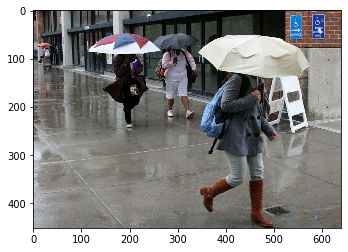

In [35]:
from matplotlib.pyplot import imshow
imshow(np.asarray(sample_img))
print(cats_list)